### Try to build our own NDE, not conditioned on anything. Only work on magnitudes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor, optim, FloatTensor
import pickle
import matplotlib.pyplot as plt
import numpy as np
import corner
from tqdm import trange

In [3]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [4]:
## Load the NN emulator for mags: `Photulator`
with open('./phot_best_loss_model.pkl', 'rb') as f:
    photulator = pickle.load(f)

In [5]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
# log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

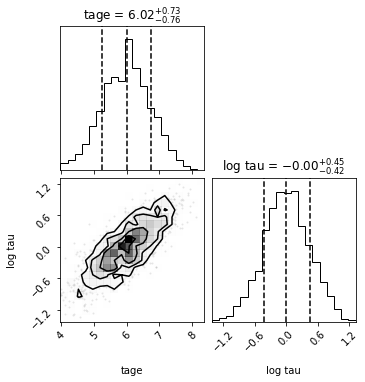

In [6]:
y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=1560)
y_test = Tensor(y_test)
x_test = photulator.predict_mag(y_test).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

figure = corner.corner(y_test.cpu().detach().numpy(), quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})


In [7]:
mag_all = -2.5 * np.log10(phot_all).astype('float32')

In [8]:
from popsed.nde import _KL_w2009_eq29, diff_KL_w2009_eq29

In [9]:
X = FloatTensor(mag_all).to('cpu')
Y = x_test.cpu()

In [10]:
%%time
_KL_w2009_eq29(X, Y, silent=False)

  epsilons  [0.92727783 0.92710736 0.92693592 ... 0.1437818  0.14537773 0.13542357]
  l_i  [235 235 235 ...  43  44  44]
  k_i  [1 1 1 ... 1 1 1]
  first term = 0.062045
  digamma term = 4.027839
CPU times: user 1.33 s, sys: 3.78 ms, total: 1.33 s
Wall time: 1.33 s


4.090524811678741

In [11]:
%%time
diff_KL_w2009_eq29(X, Y, silent=False)

  epsilons  tensor([0.9270, 0.9270, 0.9281,  ..., 0.1398, 0.1466, 0.1326],
       dtype=torch.float64)
  l_i  tensor([235, 235, 235,  ...,  41,  46,  44])
  k_i  tensor([1, 1, 1,  ..., 1, 1, 1])
  first term = -0.016130
  digamma term = 3.876601
CPU times: user 486 ms, sys: 44.6 ms, total: 531 ms
Wall time: 548 ms


tensor(3.8611, dtype=torch.float64)

### First, we fit a NDE to `x_test`

In [12]:
from popsed.nde import NeuralDensityEstimator

In [81]:
NDE = NeuralDensityEstimator(method='nsf')
NDE.build(x_test, optimizer='adam')

Training NDE: 100%|██████████████████████████████████████████████████████████████████| 4000/4000 [03:14<00:00, 20.53epochs/s]


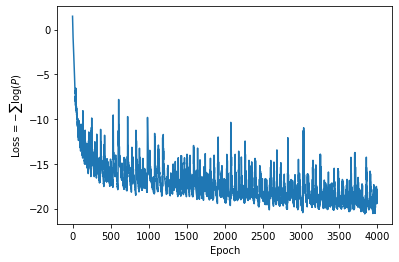

In [83]:
NDE.train(n_epochs=4000, display=True)

In [13]:
with open('./best_loss_model_nde_nsf.pkl', 'rb') as f:
    NDE = pickle.load(f)

In [14]:
samples = NDE.sample(2000)

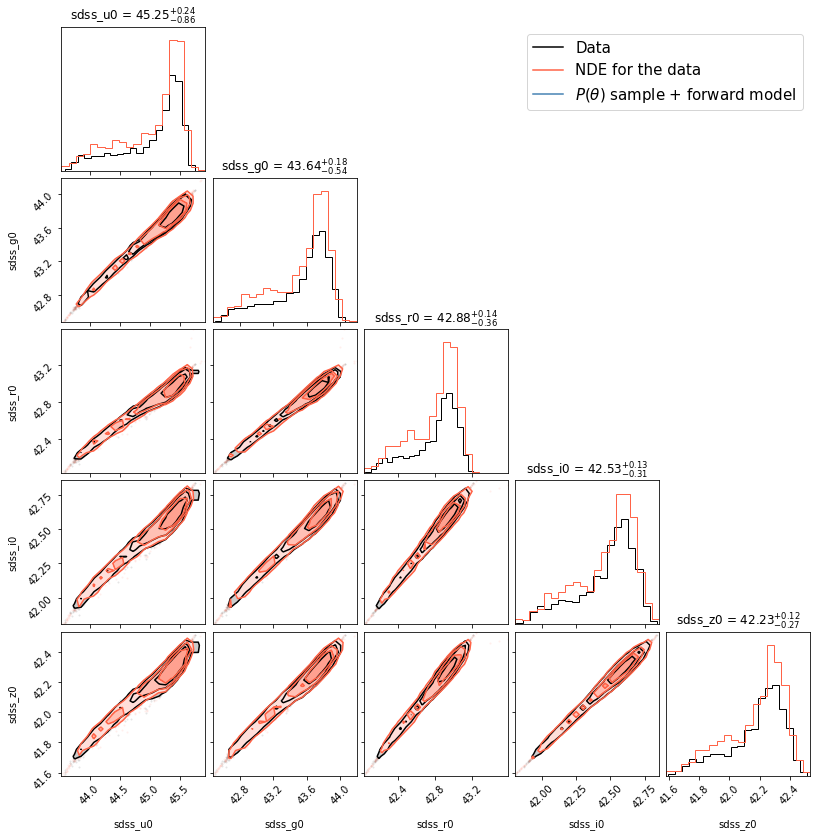

In [16]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='steelblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='tomato', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

# nf_plot = corner.corner(photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy(), 
#                   fig=figure, labels=labels,
#                   color='steelblue', #quantiles=[0.16, 0.5, 0.84], 
#                   smooth=0.5, fill_contours=True,
#                   show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, r_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

### Second, we try to achieve our goal, with loss = NDE.log_prob(X), where X is the model output.

In [17]:
NDE_theta = NeuralDensityEstimator(method='maf')
NDE_theta.build(y_test, optimizer='adam')

In [128]:
# from scipy.stats import entropy

In [129]:
# test = photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy()

In [41]:
X = NDE.sample(2000).cpu()
Y = photulator.predict_mag(NDE_theta.sample(2000)).cpu()

In [45]:
n = X.shape[0]

In [46]:
eps = [0.5]

In [39]:
diff_KL_w2009_eq29(NDE.sample(2000).cpu(), 
                   photulator.predict_mag(NDE_theta.sample(2000)).cpu(), silent=False)

tensor([[0.0000, 0.0000, 0.0000,  ..., 2.2904, 2.3310, 2.5845],
        [0.0000, 0.0442, 0.0442,  ..., 2.7560, 2.7986, 3.0375],
        [0.0000, 0.0000, 0.0000,  ..., 2.5579, 2.5985, 2.8456],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.3171, 2.3481, 2.3556],
        [0.0000, 0.0000, 0.0000,  ..., 2.9255, 2.9557, 2.9633],
        [0.0000, 0.0000, 0.0000,  ..., 2.0884, 2.1204, 2.4012]])
  epsilons  tensor([0.0000, 0.0000, 0.0442,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
  l_i  tensor([ 4,  1, 21,  ..., 26, 37,  7])
  k_i  tensor([ 1,  3,  1,  ...,  2, 10,  1])
  first term = -0.000527
  digamma term = 2.542143


tensor(2.5421, dtype=torch.float64)

In [29]:
torch.sum(rho_i == 0)

tensor(1237)

In [33]:
mask = ~torch.isinf(torch.log(rho_i / nu_i))
torch.nansum(torch.log(rho_i / nu_i)[mask])

tensor(-1.2392, dtype=torch.float64)

In [136]:
std = torch.cov(photulator.predict_mag(NDE_theta.sample(2000))).norm()

tensor(3090.9858, device='cuda:0', grad_fn=<CopyBackwards>)

In [143]:
for epoch in trange(1000, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    # loss = KL_w2009_eq29(NDE.sample(2000), photulator.predict_mag(NDE_theta.sample(2000)))
    std = torch.std(photulator.predict_mag(NDE_theta.sample(2000)), axis=0).mean()
    loss = -NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean() - torch.log(std)
    # Log(P) loss is wrong in this case.
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())
#     if loss.item() < -19:
#         break

Training NDE_theta: 100%|████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.37epochs/s]


In [23]:
from popsed.nde import KL_w2009_eq29

In [28]:
KL_w2009_eq29(-2.5 * np.log10(phot_all), photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy())

  epsilons  [1.30764008 1.30824714 1.30904263 ... 0.16148892 0.15581812 0.15438161]
  l_i  [378 378 381 ...  50  48  53]
  k_i  [1 1 1 ... 1 1 1]
  first term = 0.072403
  digamma term = 4.830378


5.151884295360714

In [16]:
photulator.predict_mag(NDE_theta.sample(2000))

tensor([[45.4832, 43.8423, 43.0448, 42.6832, 42.3729],
        [45.4306, 43.7688, 42.9671, 42.6041, 42.2979],
        [45.5283, 43.8620, 43.0503, 42.6856, 42.3740],
        ...,
        [45.4188, 43.7581, 42.9577, 42.5953, 42.2896],
        [45.5562, 43.8833, 43.0670, 42.7004, 42.3876],
        [45.5710, 43.8960, 43.0780, 42.7107, 42.3971]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [17]:
NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean()

tensor(22.3352, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
NDE.net.log_prob(NDE.sample(20000)).nanmean()

tensor(19.1063, device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
-NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean()

tensor(-22.3498, device='cuda:0', grad_fn=<NegBackward0>)

(-30.0, 0.0)

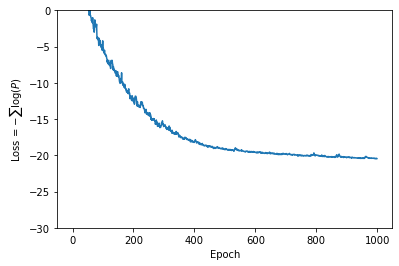

In [144]:
NDE_theta.plot_loss()
plt.ylim(-30, 0)

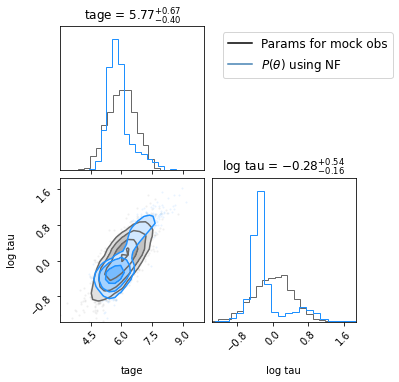

In [145]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'$P(\theta)$ using NF')

labels = ['tage', 'log tau']

figure = corner.corner(y_test.cpu().detach().numpy(), 
                       color='dimgray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(NDE_theta.sample(2000).cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=12, bbox_to_anchor=(0., 1.0, 1.3, .0))